## Financial Programming Group3 assignment

### 1. Read the data in csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
import os

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import banking data
# Note: This data was extracted on 1999

# Each record describes characteristics of a client
client = pd.read_csv('./data/data_berka/client.asc', sep=';')

# Each record describes static characteristics of an account
account = pd.read_csv('./data/data_berka/account.asc', sep=';')

# Each record describes a credit card issued to an account
card = pd.read_csv('./data/data_berka/card.asc', sep=';')

# Each record describes demographic characteristics of a district
district = pd.read_csv('./data/data_berka/district.asc', sep=';')

# Each record relates together a client with an account
# i.e. this relation describes the rights of clients to operate accounts
disp = pd.read_csv('./data/data_berka/disp.asc', sep=';')

# Each record describes characteristics of a payment order (debits only)
order = pd.read_csv('./data/data_berka/order.asc', sep=';')

# Each record describes one transaction on an account
trans = pd.read_csv('./data/data_berka/trans.asc', sep=';', low_memory=False)

# Each record describes a loan granted for a given account
loan = pd.read_csv('./data/data_berka/loan.asc', sep=';')

### 2. Create independent variables

##### 2.1 Create the independent variable --- LOR

Select the accounts that openned before 1996 to have sufficient data for IV period

In [8]:
account.head()
account['year']= account['date'].astype(str).str[:2].astype(int) + 1900
df_independent = account[account['year'] < 1996].copy(deep=True)
df_independent.head()

,account_id,district_id,frequency,date,year
0,576,55,POPLATEK MESICNE,930101,1993
1,3818,74,POPLATEK MESICNE,930101,1993
2,704,55,POPLATEK MESICNE,930101,1993
3,2378,16,POPLATEK MESICNE,930101,1993
4,2632,24,POPLATEK MESICNE,930102,1993


In [9]:
# Add length of relationship in year
df_independent['LOR'] = 1996 - df_independent['year']
df_independent.head()

,account_id,district_id,frequency,date,year,LOR
0,576,55,POPLATEK MESICNE,930101,1993,3
1,3818,74,POPLATEK MESICNE,930101,1993,3
2,704,55,POPLATEK MESICNE,930101,1993,3
3,2378,16,POPLATEK MESICNE,930101,1993,3
4,2632,24,POPLATEK MESICNE,930102,1993,3


##### 2.2 Create the independent variables --- Gender, age, age group

In [11]:
# Add information about account owner
df_independent = pd.merge(df_independent, disp[disp['type'] == 'OWNER'], how='left', on='account_id')
df_independent = pd.merge(df_independent, client, how='left', on='client_id')
df_independent = df_independent.rename(columns={'district_id_x':'bank_district_id',
                        'district_id_y':'client_district_id'})
df_independent.head()

,account_id,bank_district_id,frequency,date,year,LOR,disp_id,client_id,type,birth_number,client_district_id
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24


In [12]:
df_independent

,account_id,bank_district_id,frequency,date,year,LOR,disp_id,client_id,type,birth_number,client_district_id
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24
...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,1,5384,5384,OWNER,350721,73
2235,3814,74,POPLATEK MESICNE,951227,1995,1,4596,4596,OWNER,735831,74
2236,2780,63,POPLATEK MESICNE,951229,1995,1,3357,3357,OWNER,545721,63
2237,3273,74,POPLATEK MESICNE,951229,1995,1,3962,3962,OWNER,521128,74


In [13]:
# Transform the birth day into year
df_independent['birth_year'] = '19' + df_independent['birth_number'].astype(str).str[:2]
df_independent['birth_year'] = df_independent['birth_year'].astype(int)

# Transform the birth day to day
df_independent['birth_day'] = df_independent['birth_number'].astype(str).str[-2:].astype(int)

# Extract the birth month
df_independent['birth_month'] = df_independent['birth_number'].astype(str).str[2:4].astype(int)

# Extract and correct the gender
df_independent['gender'] = 'M'
df_independent.loc[df_independent['birth_month'] > 50, 'gender'] = 'F'

# Correct the birth month
df_independent.loc[df_independent['birth_month'] > 50, 'birth_month'] = df_independent.loc[df_independent['birth_month'] > 50, 'birth_month'] - 50
df_independent.head()

,account_id,bank_district_id,frequency,date,year,LOR,disp_id,client_id,type,birth_number,client_district_id,birth_year,birth_day,birth_month,gender
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74,1936,11,1,F
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1,1935,2,4,M
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22,1945,14,1,M
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16,1975,24,3,F
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24,1938,12,8,M


In [14]:
# Age
df_independent['age'] = 1996 - df_independent['birth_year']

# Age group
df_independent['age_group'] = df_independent['age'] // 10 * 10
df_independent.head()

,account_id,bank_district_id,frequency,date,year,LOR,disp_id,client_id,type,birth_number,client_district_id,birth_year,birth_day,birth_month,gender,age,age_group
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74,1936,11,1,F,60,60
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1,1935,2,4,M,61,60
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22,1945,14,1,M,51,50
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16,1975,24,3,F,21,20
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24,1938,12,8,M,58,50


##### 2.3 Create the independent variables--- (Recency, Frequency, Monetary)

In [16]:
#Merging table trans and account
transmerge = pd.merge(trans, account, on = 'account_id')
transmerge = transmerge.rename(columns= {'date_x': 'trans_date'})
transmerge = transmerge.rename(columns= {'date_y': 'dateacc'})

transmerge2 = pd.merge(transmerge, disp, on = 'account_id')
transmerge2 = transmerge2.rename(columns= {'type_y': 'type_client'})
transmerge2 = transmerge2.rename(columns= {'type_x': 'type_trans'})

transmerge2.head()

,trans_id,account_id,trans_date,type_trans,operation,amount,balance,k_symbol,bank,account,district_id,frequency,dateacc,year,disp_id,client_id,type_client
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN,16,POPLATEK MESICNE,930101,1993,2873,2873,OWNER
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN,55,POPLATEK MESICNE,930101,1993,692,692,OWNER
2,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN,55,POPLATEK MESICNE,930101,1993,693,693,DISPONENT
3,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN,55,POPLATEK MESICNE,930101,1993,844,844,OWNER
4,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN,55,POPLATEK MESICNE,930101,1993,845,845,DISPONENT


In [17]:
# Select on transactions in and 1996
trans96 = transmerge2[transmerge2['trans_date'].astype(str).str[:2].isin(['96'])]
trans96.head()

,trans_id,account_id,trans_date,type_trans,operation,amount,balance,k_symbol,bank,account,district_id,frequency,dateacc,year,disp_id,client_id,type_client
304624,732811,2504,960101,VYDAJ,VYBER KARTOU,900.0,38124.4,NaN,NaN,0.0,16,POPLATEK MESICNE,931209,1993,3023,3023,OWNER
304625,800209,2729,960101,VYDAJ,VYBER,1920.0,34202.7,NaN,NaN,NaN,40,POPLATEK MESICNE,950116,1995,3295,3295,OWNER
304626,803553,2738,960101,VYDAJ,VYBER,6500.0,25685.2,NaN,NaN,NaN,41,POPLATEK MESICNE,931112,1993,3305,3305,OWNER
304627,1042686,3566,960101,VYDAJ,VYBER,1000.0,25919.7,NaN,NaN,NaN,21,POPLATEK MESICNE,930609,1993,4303,4303,OWNER
304628,1042689,3566,960101,VYDAJ,VYBER,500.0,25419.7,NaN,NaN,NaN,21,POPLATEK MESICNE,930609,1993,4303,4303,OWNER


2.3.1 Recency calculation

In [20]:
# Convert the 'date' column to datetime format
trans96['trans_date'] = pd.to_datetime(trans96['trans_date'], format='%y%m%d', errors='coerce')

# Subset of transaction data with only 'client_id' and 'trans_date'
purchase_date = trans96[['client_id', 'trans_date']]

# Group by 'client_id' and find the latest (maximum) purchase date for each client
last_purchase_date = purchase_date.groupby('client_id')['trans_date'].max().reset_index()

last_purchase_date['trans_date'].value_counts()
#checking the dates

last_purchase_date

,client_id,trans_date
0,1,1996-12-31
1,2,1996-12-31
2,3,1996-12-31
3,6,1996-12-31
4,8,1996-12-31
...,...,...
4285,13955,1996-12-31
4286,13956,1996-12-31
4287,13968,1996-12-31
4288,13971,1996-12-31


In [21]:
#setting a reference date
reference_date = pd.to_datetime('1996-12-31')

last_purchase_date['recency_days'] = (reference_date - last_purchase_date['trans_date']).dt.days

last_purchase_date.head()

,client_id,trans_date,recency_days
0,1,1996-12-31,0
1,2,1996-12-31,0
2,3,1996-12-31,0
3,6,1996-12-31,0
4,8,1996-12-31,0


In [22]:
last_purchase_date = last_purchase_date.drop('trans_date', axis= 1)
last_purchase_date.head()

,client_id,recency_days
0,1,0
1,2,0
2,3,0
3,6,0
4,8,0


In [23]:
#merging with the basetable
df_independent = pd.merge(df_independent, last_purchase_date, how= 'left', on= 'client_id')

2.3.2 Frequency - count of transactions per client

In [26]:
frequency_df = trans96.groupby('client_id').size().reset_index(name='frequency')

frequency_df.head()

,client_id,frequency
0,1,74
1,2,85
2,3,85
3,6,39
4,8,63


In [27]:
#merge frequency with the basetable
df_independent = pd.merge(df_independent, frequency_df, how= 'left', on= 'client_id')
df_independent = df_independent.rename(columns= {'frequency_x': 'freq iss. stats'})
df_independent = df_independent.rename(columns= {'frequency_y': 'frequency'})

2.3.3 Monetary - the total amount of money a client has spent during 1996

In [30]:
# Calculate the total monetary value for each client
monetary_df = trans96.groupby('client_id')['amount'].sum().reset_index(name='monetary')
monetary_df

,client_id,monetary
0,1,105645.2
1,2,563117.1
2,3,563117.1
3,6,88898.1
4,8,163310.9
...,...,...
4285,13955,1093960.3
4286,13956,1093960.3
4287,13968,704593.7
4288,13971,433577.6


In [31]:
#merge monetary with the basetable
df_independent = pd.merge(df_independent, monetary_df, how= 'left', on= 'client_id')

**2.4 Create the independent variables--- (Total credit per client, Total withdrawal per client, Credit and Withdrawal frequency per client)**

2.4.1 Total credit per client

In [34]:
# Aggregate the total credit per account
trans_agg_credit = trans96[trans96['type_trans'].isin(['PRIJEM'])].groupby('client_id')['amount'].agg('sum')
trans_agg_credit = trans_agg_credit.reset_index()
trans_agg_credit = trans_agg_credit.rename(columns={'amount':'total_credit'})
trans_agg_credit.head()

,client_id,total_credit
0,1,50066.0
1,2,288542.9
2,3,288542.9
3,6,56920.5
4,8,81507.7


2.4.2 Total withdrawal per client

In [36]:
# Aggregate the total withdrawal per account
trans_agg_withdrawal = trans96[trans96['type_trans'].isin(['VYDAJ','VYBER'])].groupby('client_id')['amount'].agg('sum')
trans_agg_withdrawal = trans_agg_withdrawal.reset_index()
trans_agg_withdrawal = trans_agg_withdrawal.rename(columns={'amount':'total_withdrawal'})
trans_agg_withdrawal.head()

,client_id,total_withdrawal
0,1,55579.2
1,2,274574.2
2,3,274574.2
3,6,31977.6
4,8,81803.2


In [37]:
# Join with previous table
df_independent = pd.merge(df_independent, trans_agg_credit,how ='left', on='client_id')
df_independent = pd.merge(df_independent, trans_agg_withdrawal, how='left', on='client_id')
df_independent.head()

,account_id,bank_district_id,freq iss. stats,date,year,LOR,disp_id,client_id,type,birth_number,...,birth_day,birth_month,gender,age,age_group,recency_days,frequency,monetary,total_credit,total_withdrawal
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,...,11,1,F,60,60,0,62,146516.5,76097.3,70419.2
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,...,2,4,M,61,60,0,98,458341.6,234806.4,223535.2
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,...,14,1,M,51,50,0,84,447046.1,228514.9,218531.2
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,...,24,3,F,21,20,0,83,1297855.6,664545.4,633310.2
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,...,12,8,M,58,50,0,98,377730.1,186658.9,191071.2


2.4.3 Credit and withdrawal frequency per client

In [39]:
transaction_freq = trans96

In [40]:
transaction_freq['transaction_category'] = transaction_freq['type_trans'].replace({
    'PRIJEM': 'credit',
    'VYDAJ': 'withdrawal',
    'VYBER': 'withdrawal'
})

In [41]:
transaction_frequency = transaction_freq.groupby(['client_id', 'transaction_category']).size().unstack().reset_index()
transaction_frequency.columns = ['client_id', 'credit_frequency', 'withdrawal_frequency']

In [42]:
df_independent = pd.merge(df_independent, transaction_frequency, how='left', on='client_id')
df_independent.head()

,account_id,bank_district_id,freq iss. stats,date,year,LOR,disp_id,client_id,type,birth_number,...,gender,age,age_group,recency_days,frequency,monetary,total_credit,total_withdrawal,credit_frequency,withdrawal_frequency
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,...,F,60,60,0,62,146516.5,76097.3,70419.2,24.0,38.0
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,...,M,61,60,0,98,458341.6,234806.4,223535.2,25.0,73.0
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,...,M,51,50,0,84,447046.1,228514.9,218531.2,24.0,60.0
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,...,F,21,20,0,83,1297855.6,664545.4,633310.2,34.0,49.0
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,...,M,58,50,0,98,377730.1,186658.9,191071.2,24.0,74.0


##### 2.5 Create other transaction related variables

2.5.1 The average and std of transaction amount in 1996 for each client -- avg_amount_trans_96, trans_std_96

 The variable represents the Average amount per transaction per client for the year of 1996

In [46]:
# Find the average lifetime transaction amount for each client
avg_amount_trans_96 = trans96.groupby('client_id')['amount'].agg('mean')
avg_amount_trans_96 = avg_amount_trans_96.reset_index()
avg_amount_trans_96 = avg_amount_trans_96.rename(columns={'amount':'avg_amount_trans_96'})

# Join the previous basetable
df_independent = pd.merge(df_independent, avg_amount_trans_96, how='left', on='client_id')

In [47]:
transaction_std = trans96.groupby('client_id')['amount'].std().reset_index()
transaction_std.columns = ['client_id', 'transaction_std']
transaction_std.head()

# Join the previous basetable
df_independent = pd.merge(df_independent, transaction_std, how='left', on='client_id')

2.5.2 Average and std of account balances after all transactions in 1996 for each client -- avg_balance_96, std_balance_96

In [49]:
trans_data = trans96
trans_data = trans_data.sort_values(by=['client_id', 'trans_date'])

# Calculate the average balance for each client
avg_balance = trans_data.groupby('client_id')['balance'].mean().reset_index()

# Rename the balance column for clarity
avg_balance = avg_balance.rename(columns={'balance': 'avg_balance'})

In [50]:
balance_std = trans_data.groupby('client_id')['amount'].std().reset_index()
balance_std.columns = ['client_id', 'balance_std']
balance_std.head()

,client_id,balance_std
0,1,1427.130533
1,2,7602.794537
2,3,7602.794537
3,6,2179.889656
4,8,2787.811379


In [51]:
# Join with previous table
df_independent = pd.merge(df_independent, avg_balance,how ='left', on='client_id')
df_independent = pd.merge(df_independent, balance_std, how='left', on='client_id')
df_independent.head()

,account_id,bank_district_id,freq iss. stats,date,year,LOR,disp_id,client_id,type,birth_number,...,frequency,monetary,total_credit,total_withdrawal,credit_frequency,withdrawal_frequency,avg_amount_trans_96,transaction_std,avg_balance,balance_std
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,...,62,146516.5,76097.3,70419.2,24.0,38.0,2363.169355,2469.018420,33263.845161,2469.018420
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,...,98,458341.6,234806.4,223535.2,25.0,73.0,4676.955102,6125.480217,47088.326531,6125.480217
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,...,84,447046.1,228514.9,218531.2,24.0,60.0,5321.977381,7068.973119,26333.983333,7068.973119
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,...,83,1297855.6,664545.4,633310.2,34.0,49.0,15636.814458,15800.741309,71777.087952,15800.741309
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,...,98,377730.1,186658.9,191071.2,24.0,74.0,3854.388776,5274.244269,25321.784694,5274.244269


Drop Non Necessary Columns

In [53]:
df_independent.columns

Index(['account_id', 'bank_district_id', 'freq iss. stats', 'date', 'year',
       'LOR', 'disp_id', 'client_id', 'type', 'birth_number',
       'client_district_id', 'birth_year', 'birth_day', 'birth_month',
       'gender', 'age', 'age_group', 'recency_days', 'frequency', 'monetary',
       'total_credit', 'total_withdrawal', 'credit_frequency',
       'withdrawal_frequency', 'avg_amount_trans_96', 'transaction_std',
       'avg_balance', 'balance_std'],
      dtype='object')

In [54]:
needed_variables=['client_id','freq iss. stats','LOR','gender','age_group',
                  'total_credit', 'total_withdrawal', 'credit_frequency','withdrawal_frequency',
                  'avg_amount_trans_96', 'transaction_std','avg_balance', 'balance_std',
                  'recency_days', 'frequency', 'monetary', 'client_district_id']

In [55]:
df_independent=df_independent[needed_variables]

In [56]:
df_independent.head()

,client_id,freq iss. stats,LOR,gender,age_group,total_credit,total_withdrawal,credit_frequency,withdrawal_frequency,avg_amount_trans_96,transaction_std,avg_balance,balance_std,recency_days,frequency,monetary,client_district_id
0,692,POPLATEK MESICNE,3,F,60,76097.3,70419.2,24.0,38.0,2363.169355,2469.018420,33263.845161,2469.018420,0,62,146516.5,74
1,4601,POPLATEK MESICNE,3,M,60,234806.4,223535.2,25.0,73.0,4676.955102,6125.480217,47088.326531,6125.480217,0,98,458341.6,1
2,844,POPLATEK MESICNE,3,M,50,228514.9,218531.2,24.0,60.0,5321.977381,7068.973119,26333.983333,7068.973119,0,84,447046.1,22
3,2873,POPLATEK MESICNE,3,F,20,664545.4,633310.2,34.0,49.0,15636.814458,15800.741309,71777.087952,15800.741309,0,83,1297855.6,16
4,3177,POPLATEK MESICNE,3,M,50,186658.9,191071.2,24.0,74.0,3854.388776,5274.244269,25321.784694,5274.244269,0,98,377730.1,24


##### 2.6 Create district related variables

In [58]:
df_dis = df_independent[['client_id','client_district_id']]
df_ds1 = pd.merge(df_dis, district, left_on='client_district_id', right_on='A1', how='left')

In [59]:
df_ds1 = df_ds1[['client_id', 'A10', 'A11', 'A13']]
df_ds1 = df_ds1.rename(columns={'A10':'urban_inhabitant_ratio', 'A11':'avg_dist_salary', 'A13':'dist_unemploy_rate'})

In [60]:
df_independent = pd.merge(df_independent, df_ds1, how='left', on='client_id')

In [61]:
df_independent = df_independent.drop(columns = 'client_district_id')

In [62]:
df_independent.head()

,client_id,freq iss. stats,LOR,gender,age_group,total_credit,total_withdrawal,credit_frequency,withdrawal_frequency,avg_amount_trans_96,transaction_std,avg_balance,balance_std,recency_days,frequency,monetary,urban_inhabitant_ratio,avg_dist_salary,dist_unemploy_rate
0,692,POPLATEK MESICNE,3,F,60,76097.3,70419.2,24.0,38.0,2363.169355,2469.018420,33263.845161,2469.018420,0,62,146516.5,100.0,10673,5.44
1,4601,POPLATEK MESICNE,3,M,60,234806.4,223535.2,25.0,73.0,4676.955102,6125.480217,47088.326531,6125.480217,0,98,458341.6,100.0,12541,0.43
2,844,POPLATEK MESICNE,3,M,50,228514.9,218531.2,24.0,60.0,5321.977381,7068.973119,26333.983333,7068.973119,0,84,447046.1,52.4,8620,1.25
3,2873,POPLATEK MESICNE,3,F,20,664545.4,633310.2,34.0,49.0,15636.814458,15800.741309,71777.087952,15800.741309,0,83,1297855.6,56.9,8427,1.54
4,3177,POPLATEK MESICNE,3,M,50,186658.9,191071.2,24.0,74.0,3854.388776,5274.244269,25321.784694,5274.244269,0,98,377730.1,80.0,8991,2.01


### 3. Create dependent variable (or target variable)

##### Create target variable1: granted_loan and target variable2: card_issued

In [65]:
# Select on transactions in 1997
loan_1997 = loan[loan['date'].astype(str).str[:2].isin(['97'])]
card_1997 = card[card['issued'].astype(str).str[:2].isin(['97'])]
print(loan_1997.head(5))
print(card_1997.head(5))

     loan_id  account_id    date  amount  duration  payments status
328     5895        4473  970103   93960        60    1566.0      C
329     7122       10365  970104  260640        36    7240.0      D
330     6173        5724  970108  232560        48    4845.0      C
331     6142        5591  970121  221880        60    3698.0      C
332     5358        2018  970121   38520        12    3210.0      A
     card_id  disp_id     type           issued
201     1118    11393  classic  970102 00:00:00
202      175     1040  classic  970103 00:00:00
203      565     3601     gold  970106 00:00:00
204      714     4638  classic  970109 00:00:00
205      137      786   junior  970110 00:00:00


In [66]:
df_dependent = account[account['year'] < 1996].copy(deep=True)
df_dependent = pd.merge(df_dependent, disp[disp['type'] == 'OWNER'], how='left', on='account_id')
df_dependent = pd.merge(df_dependent, client, how='left', on='client_id')
df_dependent.head()

,account_id,district_id_x,frequency,date,year,disp_id,client_id,type,birth_number,district_id_y
0,576,55,POPLATEK MESICNE,930101,1993,692,692,OWNER,365111,74
1,3818,74,POPLATEK MESICNE,930101,1993,4601,4601,OWNER,350402,1
2,704,55,POPLATEK MESICNE,930101,1993,844,844,OWNER,450114,22
3,2378,16,POPLATEK MESICNE,930101,1993,2873,2873,OWNER,755324,16
4,2632,24,POPLATEK MESICNE,930102,1993,3177,3177,OWNER,380812,24


In [67]:
df_dependent = pd.merge(df_dependent, loan_1997, how='left', on='account_id')
df_dependent = pd.merge(df_dependent, card_1997, how='left', on='disp_id')
df_dependent = df_dependent.drop(['date_y','amount','duration','payments','status', 'type_y', 'issued'], axis = 1)

#Target Variable 1
df_dependent['granted_loan'] = np.where(df_dependent['loan_id'].notna() & df_dependent['loan_id'].astype(bool), 1, 0)
#Target Variable 2
df_dependent['card_issued'] = np.where(df_dependent['card_id'].notna() & df_dependent['card_id'].astype(bool), 1, 0)
df_dependent.head()

,account_id,district_id_x,frequency,date_x,year,disp_id,client_id,type_x,birth_number,district_id_y,loan_id,card_id,granted_loan,card_issued
0,576,55,POPLATEK MESICNE,930101,1993,692,692,OWNER,365111,74,NaN,NaN,0,0
1,3818,74,POPLATEK MESICNE,930101,1993,4601,4601,OWNER,350402,1,NaN,NaN,0,0
2,704,55,POPLATEK MESICNE,930101,1993,844,844,OWNER,450114,22,NaN,NaN,0,0
3,2378,16,POPLATEK MESICNE,930101,1993,2873,2873,OWNER,755324,16,NaN,NaN,0,0
4,2632,24,POPLATEK MESICNE,930102,1993,3177,3177,OWNER,380812,24,NaN,NaN,0,0


In [68]:
df_dependent['granted_loan'].value_counts()

granted_loan
0    2208
1      31
Name: count, dtype: int64

In [69]:
df_dependent['card_issued'].value_counts()

card_issued
0    2119
1     120
Name: count, dtype: int64

In [70]:
df_dependent=df_dependent[['client_id', 'granted_loan','card_issued']]

In [71]:
df_dependent.head()

,client_id,granted_loan,card_issued
0,692,0,0
1,4601,0,0
2,844,0,0
3,2873,0,0
4,3177,0,0


### 4. Data correction and Value transformation

#### 4.1 Data correction

##### 4.1.1 Missing values

In [75]:
df_independent.isna().sum()

client_id                 0
freq iss. stats           0
LOR                       0
gender                    0
age_group                 0
total_credit              1
total_withdrawal          0
credit_frequency          1
withdrawal_frequency      0
avg_amount_trans_96       0
transaction_std           0
avg_balance               0
balance_std               0
recency_days              0
frequency                 0
monetary                  0
urban_inhabitant_ratio    0
avg_dist_salary           0
dist_unemploy_rate        0
dtype: int64

In [76]:
default_directory = './Plots/'
def save_plot(filename):
    save_path = os.path.join(default_directory, filename)
    plt.savefig(save_path)

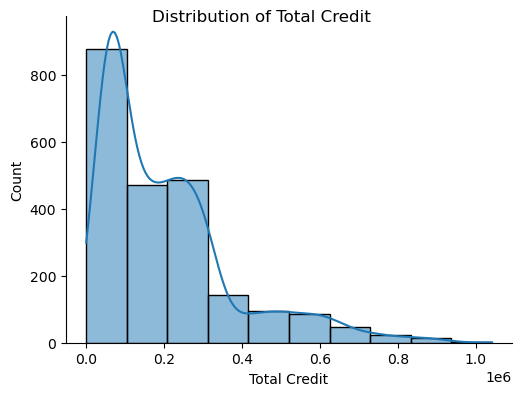

In [77]:
displot = sns.displot(data=df_independent, x="total_credit", bins= 10, kde=True, height=4, aspect=1.33)
displot.set_axis_labels("Total Credit", "Count")
displot.fig.suptitle("Distribution of Total Credit")

save = os.path.join(default_directory, "Distribution of Total Credit.png")
displot.fig.savefig(save)

In [78]:
df_independent['total_credit']=df_independent['total_credit'].fillna(df_independent['total_credit'].median())

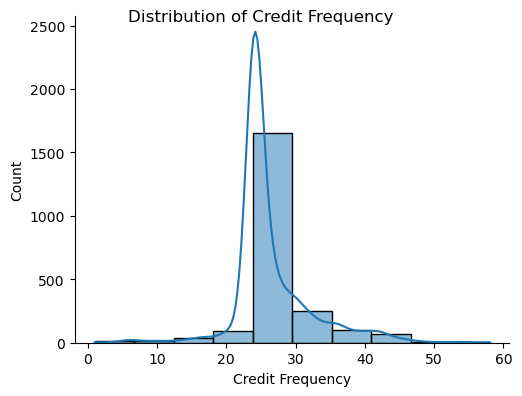

In [79]:
displot = sns.displot(data=df_independent, x="credit_frequency", bins= 10, kde=True, height=4, aspect=1.33)
displot.set_axis_labels("Credit Frequency", "Count")
displot.fig.suptitle("Distribution of Credit Frequency")

save1 = os.path.join(default_directory, "Distribution of Credit Frequency.png")
displot.fig.savefig(save1)

In [80]:
df_independent['credit_frequency']=df_independent['credit_frequency'].fillna(df_independent['credit_frequency'].median())

In [81]:
df_independent.isna().sum()

client_id                 0
freq iss. stats           0
LOR                       0
gender                    0
age_group                 0
total_credit              0
total_withdrawal          0
credit_frequency          0
withdrawal_frequency      0
avg_amount_trans_96       0
transaction_std           0
avg_balance               0
balance_std               0
recency_days              0
frequency                 0
monetary                  0
urban_inhabitant_ratio    0
avg_dist_salary           0
dist_unemploy_rate        0
dtype: int64

##### 4.1.2 Outlier

In [83]:
numerical_variables=df_independent.select_dtypes(include=['number']).columns
numerical_variables

Index(['client_id', 'LOR', 'age_group', 'total_credit', 'total_withdrawal',
       'credit_frequency', 'withdrawal_frequency', 'avg_amount_trans_96',
       'transaction_std', 'avg_balance', 'balance_std', 'recency_days',
       'frequency', 'monetary', 'urban_inhabitant_ratio', 'avg_dist_salary',
       'dist_unemploy_rate'],
      dtype='object')

In [84]:
numerical_variables = numerical_variables.drop(['client_id','LOR','age_group'])

In [85]:
for v in numerical_variables:
    print(f"Column: {v}, Data Type: {df_independent[v].dtypes}")

Column: total_credit, Data Type: float64
Column: total_withdrawal, Data Type: float64
Column: credit_frequency, Data Type: float64
Column: withdrawal_frequency, Data Type: float64
Column: avg_amount_trans_96, Data Type: float64
Column: transaction_std, Data Type: float64
Column: avg_balance, Data Type: float64
Column: balance_std, Data Type: float64
Column: recency_days, Data Type: int64
Column: frequency, Data Type: int64
Column: monetary, Data Type: float64
Column: urban_inhabitant_ratio, Data Type: float64
Column: avg_dist_salary, Data Type: int64
Column: dist_unemploy_rate, Data Type: float64


In [86]:
for v in numerical_variables:
    
    # Calculate the lower and upper boundaries based on mean +/- 3*sd
    lower = df_independent[v].mean() - 3*df_independent[v].std()
    upper = df_independent[v].mean() + 3*df_independent[v].std()
    
    # Count the number of outliers
    cnt_outlier = sum((df_independent[v] < lower) | (df_independent[v] > upper))
    
    # Print out
    if cnt_outlier > 0:
        print(v, '[', df_independent[v].dtype, ']', cnt_outlier, 'outlier(s)')
    else:
            print(f"{v} [no outliers]")

total_credit [ float64 ] 38 outlier(s)
total_withdrawal [ float64 ] 37 outlier(s)
credit_frequency [ float64 ] 50 outlier(s)
withdrawal_frequency [ float64 ] 12 outlier(s)
avg_amount_trans_96 [ float64 ] 25 outlier(s)
transaction_std [ float64 ] 7 outlier(s)
avg_balance [ float64 ] 4 outlier(s)
balance_std [ float64 ] 7 outlier(s)
recency_days [ int64 ] 17 outlier(s)
frequency [ int64 ] 30 outlier(s)
monetary [ float64 ] 38 outlier(s)
urban_inhabitant_ratio [no outliers]
avg_dist_salary [no outliers]
dist_unemploy_rate [no outliers]


In [87]:
outlier_variables1 = ['total_credit', 'total_withdrawal','credit_frequency', 'withdrawal_frequency']
outlier_variables2 = ['avg_amount_trans_96','transaction_std', 'avg_balance', 'balance_std']
outlier_variables3 = ['recency_days','frequency', 'monetary']

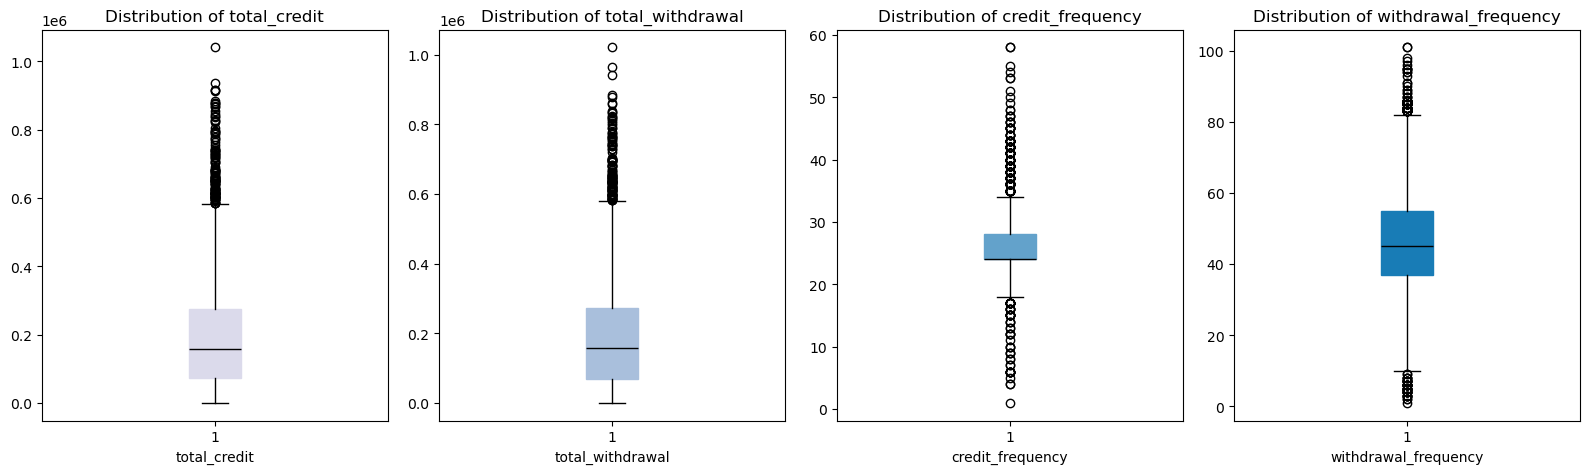

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))
colors = plt.cm.PuBu(np.linspace(0.2, 0.7, len(outlier_variables1)))

for i, var in enumerate(outlier_variables1[:4]): 
    axes[i].boxplot(df_independent[var], patch_artist=True,
                    boxprops=dict(facecolor=colors[i], color=colors[i]),
                    medianprops=dict(color='black'))
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)

plt.tight_layout()
save_plot('Boxplot of numeric variables1.png')

plt.show()

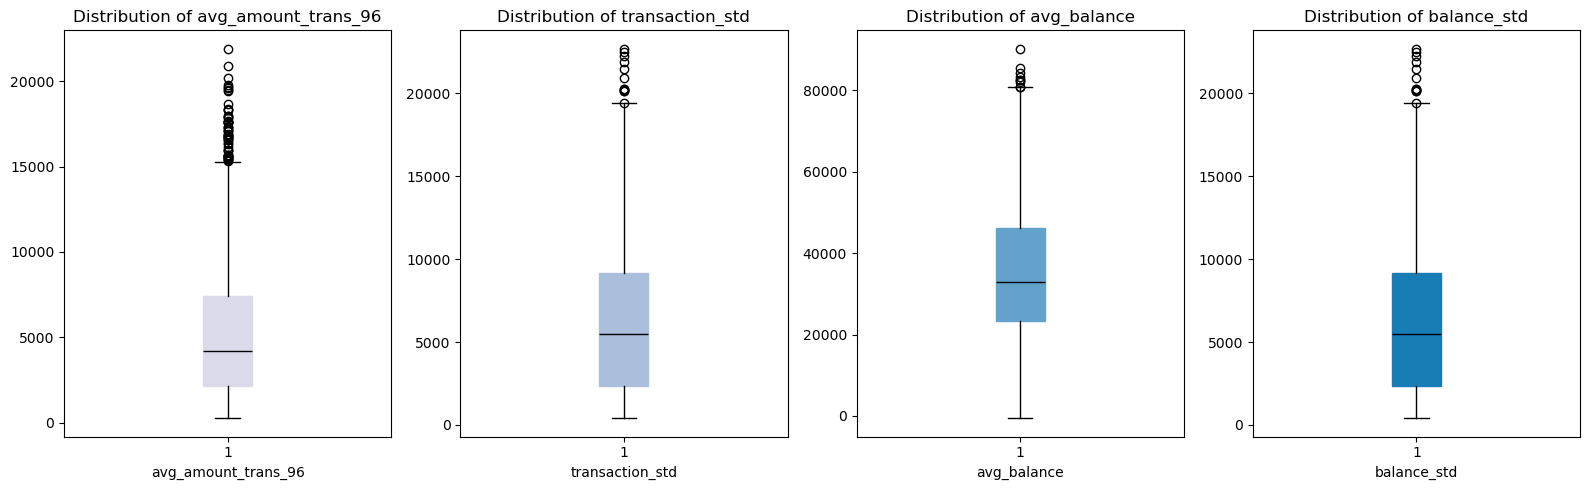

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))
colors = plt.cm.PuBu(np.linspace(0.2, 0.7, len(outlier_variables2)))

for i, var in enumerate(outlier_variables2[:4]): 
    axes[i].boxplot(df_independent[var], patch_artist=True,
                    boxprops=dict(facecolor=colors[i], color=colors[i]),
                    medianprops=dict(color='black'))
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)

plt.tight_layout()
save_plot('Boxplot of numeric variables2.png')

plt.show()

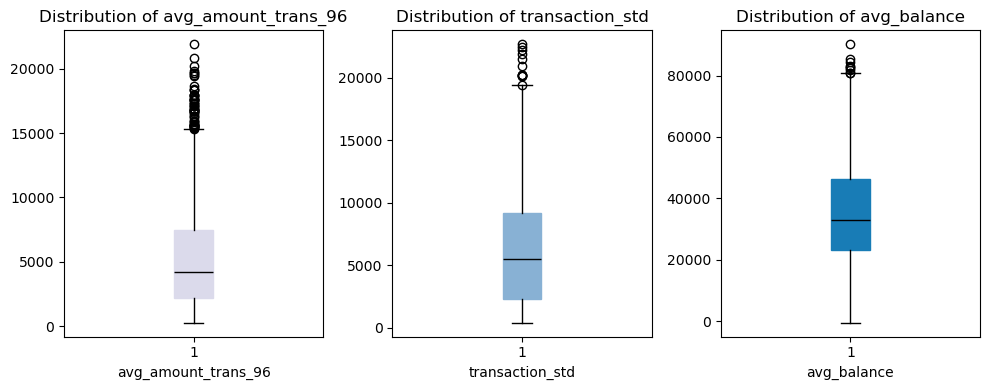

In [90]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
colors = plt.cm.PuBu(np.linspace(0.2, 0.7, len(outlier_variables3)))

for i, var in enumerate(outlier_variables2[:3]): 
    axes[i].boxplot(df_independent[var], patch_artist=True,
                    boxprops=dict(facecolor=colors[i], color=colors[i]),
                    medianprops=dict(color='black'))
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)

plt.tight_layout()
save_plot('Boxplot of numeric variables3.png')

plt.show()

In [91]:
for v in numerical_variables:

    # Calculate the lower and upper boundaries based on +/- 3*sd
    lower =df_independent[v].mean() - 3*df_independent[v].std()
    upper = df_independent[v].mean() + 3*df_independent[v].std()
    
    # Count the number of outliers
    cnt_outlier = sum((df_independent[v] < lower) | (df_independent[v] > upper))
    
    if cnt_outlier > 0:
    
        # Replace the outliers < lower boudary
        df_independent.loc[df_independent[v] < lower, v] = lower

        # Replace the outliers > upper boudary
        df_independent.loc[df_independent[v] > upper, v] = upper

In [92]:
df_independent.head()

,client_id,freq iss. stats,LOR,gender,age_group,total_credit,total_withdrawal,credit_frequency,withdrawal_frequency,avg_amount_trans_96,transaction_std,avg_balance,balance_std,recency_days,frequency,monetary,urban_inhabitant_ratio,avg_dist_salary,dist_unemploy_rate
0,692,POPLATEK MESICNE,3,F,60,76097.3,70419.2,24.0,38.0,2363.169355,2469.018420,33263.845161,2469.018420,0.0,62.0,146516.5,100.0,10673,5.44
1,4601,POPLATEK MESICNE,3,M,60,234806.4,223535.2,25.0,73.0,4676.955102,6125.480217,47088.326531,6125.480217,0.0,98.0,458341.6,100.0,12541,0.43
2,844,POPLATEK MESICNE,3,M,50,228514.9,218531.2,24.0,60.0,5321.977381,7068.973119,26333.983333,7068.973119,0.0,84.0,447046.1,52.4,8620,1.25
3,2873,POPLATEK MESICNE,3,F,20,664545.4,633310.2,34.0,49.0,15636.814458,15800.741309,71777.087952,15800.741309,0.0,83.0,1297855.6,56.9,8427,1.54
4,3177,POPLATEK MESICNE,3,M,50,186658.9,191071.2,24.0,74.0,3854.388776,5274.244269,25321.784694,5274.244269,0.0,98.0,377730.1,80.0,8991,2.01


#### 4.2 Value transformation

##### 4.2.1 Discretization

In [95]:
# Sample DataFrame with Recency, Frequency, and Monetary values
# Step 1: Assign scores to Recency, Frequency, and Monetary using quantiles
df_independent['R_Score'] = pd.cut(df_independent['recency_days'], 4, labels=[4, 3, 2, 1])
#For Recency, a lower value is better (more recent), so we reverse the labels ([4, 3, 2, 1]).
df_independent['F_Score'] = pd.cut(df_independent['frequency'], 4, labels=[1, 2, 3, 4])
df_independent['M_Score'] = pd.cut(df_independent['monetary'], 4, labels=[1, 2, 3, 4])
#For Frequency and Monetary, a higher value is better, so we use labels in ascending order ([1, 2, 3, 4]).

# Step 2: Combine R, F, M scores into a single RFM score
df_independent['RFM_Score'] = df_independent['R_Score'].astype(int)+ df_independent['F_Score'].astype(int) + df_independent['M_Score'].astype(int)

df_independent['Credit_F_Score'] = pd.cut(df_independent['credit_frequency'], 4, labels=[1, 2, 3, 4])
df_independent['Withdrawal_F_Score'] = pd.cut(df_independent['withdrawal_frequency'], 4, labels=[1, 2, 3, 4])
#For credit_frequency and withdrawal_frequency, a higher value is better, so we use labels in ascending order ([1, 2, 3, 4]).

df_independent.head()

,client_id,freq iss. stats,LOR,gender,age_group,total_credit,total_withdrawal,credit_frequency,withdrawal_frequency,avg_amount_trans_96,...,monetary,urban_inhabitant_ratio,avg_dist_salary,dist_unemploy_rate,R_Score,F_Score,M_Score,RFM_Score,Credit_F_Score,Withdrawal_F_Score
0,692,POPLATEK MESICNE,3,F,60,76097.3,70419.2,24.0,38.0,2363.169355,...,146516.5,100.0,10673,5.44,4,2,1,7,2,2
1,4601,POPLATEK MESICNE,3,M,60,234806.4,223535.2,25.0,73.0,4676.955102,...,458341.6,100.0,12541,0.43,4,3,2,9,2,4
2,844,POPLATEK MESICNE,3,M,50,228514.9,218531.2,24.0,60.0,5321.977381,...,447046.1,52.4,8620,1.25,4,3,2,9,2,3
3,2873,POPLATEK MESICNE,3,F,20,664545.4,633310.2,34.0,49.0,15636.814458,...,1297855.6,56.9,8427,1.54,4,3,4,11,3,3
4,3177,POPLATEK MESICNE,3,M,50,186658.9,191071.2,24.0,74.0,3854.388776,...,377730.1,80.0,8991,2.01,4,3,2,9,2,4


In [96]:
df_independent = df_independent.drop(['monetary', 'frequency', 'recency_days', 'credit_frequency', 'withdrawal_frequency'], axis= 1)

In [97]:
df_independent['dist_salary_avg'] = pd.cut(df_independent['avg_dist_salary'], 3, labels=['Low salary', 'Medium salary', 'High salary'])

In [98]:
df_independent = df_independent.drop(['avg_dist_salary'], axis= 1)
df_independent.head()

,client_id,freq iss. stats,LOR,gender,age_group,total_credit,total_withdrawal,avg_amount_trans_96,transaction_std,avg_balance,balance_std,urban_inhabitant_ratio,dist_unemploy_rate,R_Score,F_Score,M_Score,RFM_Score,Credit_F_Score,Withdrawal_F_Score,dist_salary_avg
0,692,POPLATEK MESICNE,3,F,60,76097.3,70419.2,2363.169355,2469.018420,33263.845161,2469.018420,100.0,5.44,4,2,1,7,2,2,Medium salary
1,4601,POPLATEK MESICNE,3,M,60,234806.4,223535.2,4676.955102,6125.480217,47088.326531,6125.480217,100.0,0.43,4,3,2,9,2,4,High salary
2,844,POPLATEK MESICNE,3,M,50,228514.9,218531.2,5321.977381,7068.973119,26333.983333,7068.973119,52.4,1.25,4,3,2,9,2,3,Low salary
3,2873,POPLATEK MESICNE,3,F,20,664545.4,633310.2,15636.814458,15800.741309,71777.087952,15800.741309,56.9,1.54,4,3,4,11,3,3,Low salary
4,3177,POPLATEK MESICNE,3,M,50,186658.9,191071.2,3854.388776,5274.244269,25321.784694,5274.244269,80.0,2.01,4,3,2,9,2,4,Low salary


##### 4.2.2 Dummy coding

In [100]:
freq_iss_encoded = pd.get_dummies(df_independent['freq iss. stats'], drop_first= True)

In [101]:
df_independent = pd.concat([df_independent, freq_iss_encoded], axis= 1)

In [102]:
df_independent = df_independent.drop('freq iss. stats', axis=1)

In [103]:
df_independent.head()

,client_id,LOR,gender,age_group,total_credit,total_withdrawal,avg_amount_trans_96,transaction_std,avg_balance,balance_std,...,dist_unemploy_rate,R_Score,F_Score,M_Score,RFM_Score,Credit_F_Score,Withdrawal_F_Score,dist_salary_avg,POPLATEK PO OBRATU,POPLATEK TYDNE
0,692,3,F,60,76097.3,70419.2,2363.169355,2469.018420,33263.845161,2469.018420,...,5.44,4,2,1,7,2,2,Medium salary,False,False
1,4601,3,M,60,234806.4,223535.2,4676.955102,6125.480217,47088.326531,6125.480217,...,0.43,4,3,2,9,2,4,High salary,False,False
2,844,3,M,50,228514.9,218531.2,5321.977381,7068.973119,26333.983333,7068.973119,...,1.25,4,3,2,9,2,3,Low salary,False,False
3,2873,3,F,20,664545.4,633310.2,15636.814458,15800.741309,71777.087952,15800.741309,...,1.54,4,3,4,11,3,3,Low salary,False,False
4,3177,3,M,50,186658.9,191071.2,3854.388776,5274.244269,25321.784694,5274.244269,...,2.01,4,3,2,9,2,4,Low salary,False,False


In [104]:
#Renaming the account statement frequency variable; if it is false for both, then it is a monthly issuance
#POPLATEK PO OBRATU:stat_issued_after_trans
#POPLATEK TYDNE: stat_issued_weekly
df_independent = df_independent.rename(columns={'POPLATEK PO OBRATU':'stat_issued_after_trans',
                                                   'POPLATEK TYDNE': 'stat_issued_weekly'})

##### 4.2.3 Log transformation

In [106]:
df_independent.describe()

,client_id,LOR,age_group,total_credit,total_withdrawal,avg_amount_trans_96,transaction_std,avg_balance,balance_std,urban_inhabitant_ratio,dist_unemploy_rate,RFM_Score
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,3413.595802,2.213488,37.405092,202845.810414,200815.812138,5286.732774,6377.519411,35855.979766,6377.519411,69.214113,3.517043,8.113444
std,2880.044705,0.871029,17.354316,167936.533641,166247.063448,3900.383938,4597.435184,15762.092602,4597.435184,19.767000,2.147729,1.386644
min,1.000000,1.000000,10.000000,295.600000,900.000000,281.410714,414.728827,-525.731250,414.728827,33.900000,0.430000,3.000000
25%,1393.000000,1.000000,20.000000,71643.600000,69750.100000,2180.818831,2333.321193,23265.855272,2333.321193,52.700000,1.960000,7.000000
50%,2874.000000,3.000000,40.000000,158249.100000,157826.000000,4189.183019,5486.702425,32808.267164,5486.702425,63.100000,3.470000,8.000000
75%,4349.500000,3.000000,50.000000,275681.600000,274053.300000,7438.187478,9165.479285,46241.108710,9165.479285,85.500000,4.790000,9.000000
max,13998.000000,3.000000,70.000000,724634.918893,715924.577785,17159.117423,20218.717624,83191.376731,20218.717624,100.000000,9.400000,12.000000


In [107]:
transform_col = ['total_credit', 'total_withdrawal', 'avg_amount_trans_96', 'transaction_std', 'avg_balance', 'balance_std']

In [108]:
for col in transform_col:
    df_independent[f'log_{col}'] = np.log(df_independent[col])

# Check the result
df_independent.head()

,client_id,LOR,gender,age_group,total_credit,total_withdrawal,avg_amount_trans_96,transaction_std,avg_balance,balance_std,...,Withdrawal_F_Score,dist_salary_avg,stat_issued_after_trans,stat_issued_weekly,log_total_credit,log_total_withdrawal,log_avg_amount_trans_96,log_transaction_std,log_avg_balance,log_balance_std
0,692,3,F,60,76097.3,70419.2,2363.169355,2469.018420,33263.845161,2469.018420,...,2,Medium salary,False,False,11.239768,11.162221,7.767759,7.811576,10.412226,7.811576
1,4601,3,M,60,234806.4,223535.2,4676.955102,6125.480217,47088.326531,6125.480217,...,4,High salary,False,False,12.366517,12.317324,8.450403,8.720212,10.759780,8.720212
2,844,3,M,50,228514.9,218531.2,5321.977381,7068.973119,26333.983333,7068.973119,...,3,Low salary,False,False,12.339357,12.294684,8.579600,8.863471,10.178616,8.863471
3,2873,3,F,20,664545.4,633310.2,15636.814458,15800.741309,71777.087952,15800.741309,...,3,Low salary,False,False,13.406858,13.358716,9.657383,9.667812,11.181321,9.667812
4,3177,3,M,50,186658.9,191071.2,3854.388776,5274.244269,25321.784694,5274.244269,...,4,Low salary,False,False,12.137038,12.160401,8.256968,8.570591,10.139420,8.570591


In [109]:
df_independent.columns

Index(['client_id', 'LOR', 'gender', 'age_group', 'total_credit',
       'total_withdrawal', 'avg_amount_trans_96', 'transaction_std',
       'avg_balance', 'balance_std', 'urban_inhabitant_ratio',
       'dist_unemploy_rate', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score',
       'Credit_F_Score', 'Withdrawal_F_Score', 'dist_salary_avg',
       'stat_issued_after_trans', 'stat_issued_weekly', 'log_total_credit',
       'log_total_withdrawal', 'log_avg_amount_trans_96',
       'log_transaction_std', 'log_avg_balance', 'log_balance_std'],
      dtype='object')

In [110]:
hist_col1 = ['total_credit', 'total_withdrawal', 'avg_amount_trans_96', 'transaction_std',
            'log_total_credit', 'log_total_withdrawal', 'log_avg_amount_trans_96', 'log_transaction_std']

In [111]:
hist_col2 = ['avg_balance', 'balance_std', 'log_avg_balance','log_balance_std']

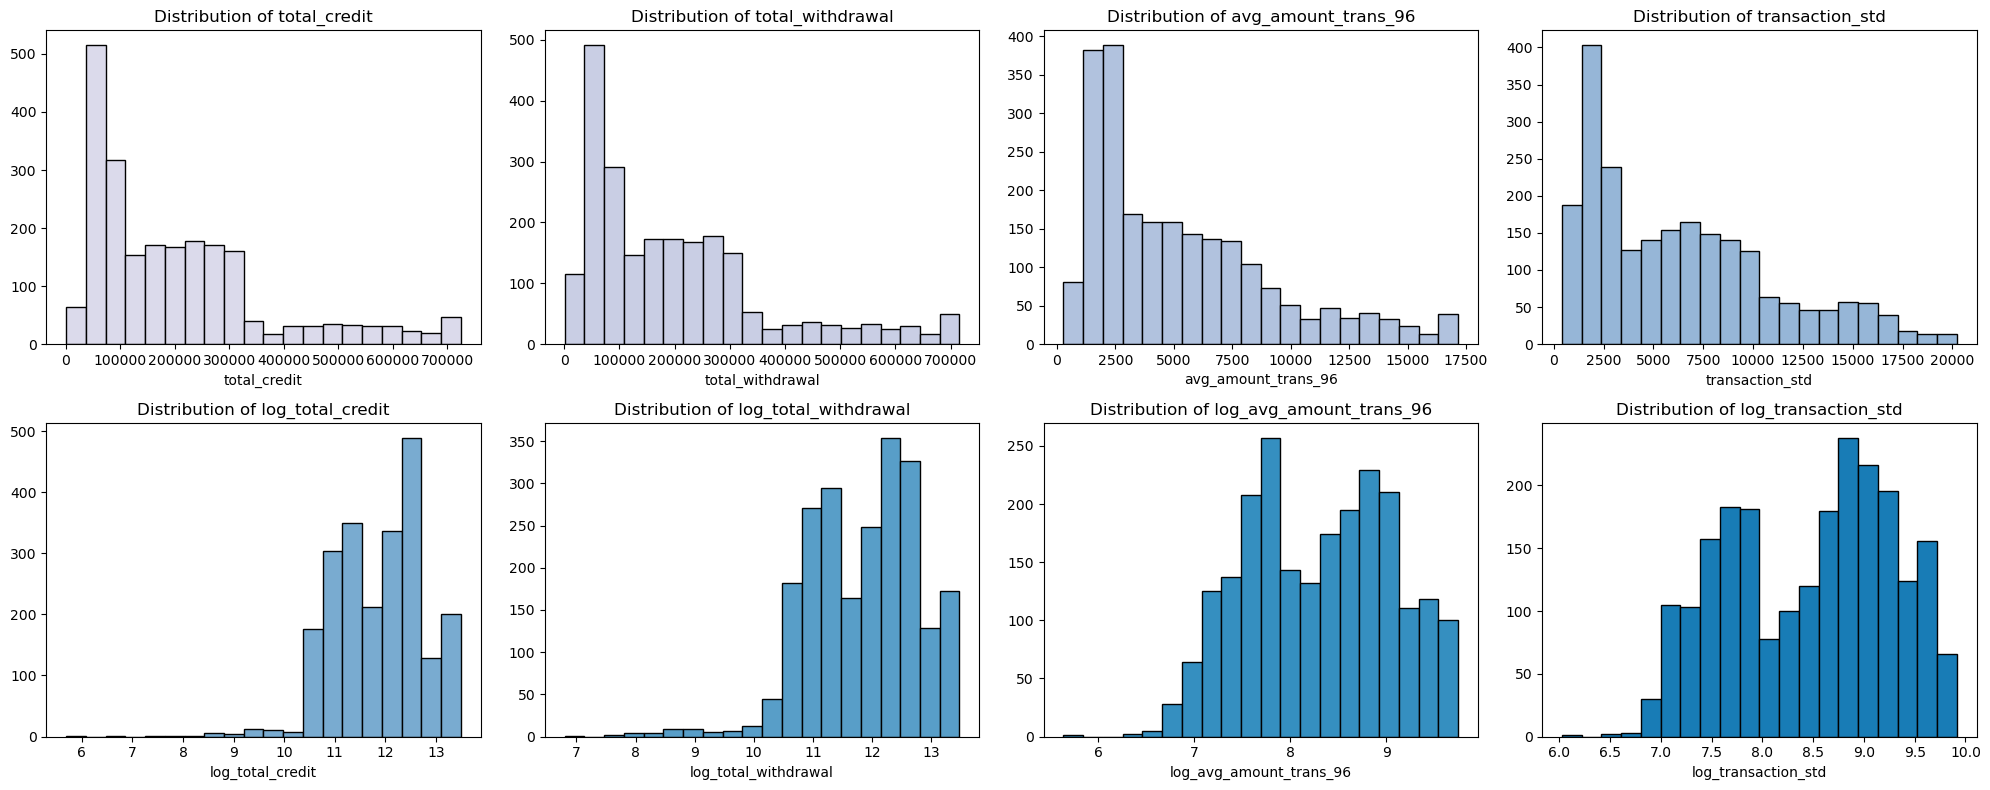

In [112]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

# Generate colors using a colormap
colors = plt.cm.PuBu(np.linspace(0.2, 0.7, len(hist_col1)))

# Loop through the list of variables
for i, var in enumerate(hist_col1):
    row, col = divmod(i, 4)
    
    axes[row, col].hist(df_independent[var], bins=20, color=colors[i], edgecolor='black')
    axes[row, col].set_title(f'Distribution of {var}')
    axes[row, col].set_xlabel(var)

plt.tight_layout()
save_plot('Histograms of log transform variables1.png')

# Show the plot
plt.show()

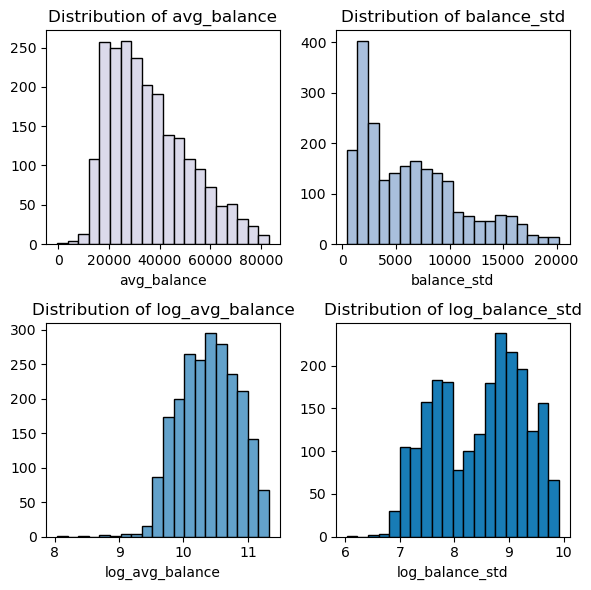

In [113]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

# Generate colors using a colormap
colors = plt.cm.PuBu(np.linspace(0.2, 0.7, len(hist_col2)))

# Loop through the list of variables
for i, var in enumerate(hist_col2):
    row, col = divmod(i, 2)
    
    axes[row, col].hist(df_independent[var], bins=20, color=colors[i], edgecolor='black')
    axes[row, col].set_title(f'Distribution of {var}')
    axes[row, col].set_xlabel(var)

plt.tight_layout()
save_plot('Histograms of log transform variables2.png')

# Show the plot
plt.show()

In [114]:
df_independent = df_independent.drop(['total_credit', 'total_withdrawal', 'avg_amount_trans_96', 'transaction_std',
                                     'avg_balance', 'balance_std'], axis =1)

In [115]:
df_independent

,client_id,LOR,gender,age_group,urban_inhabitant_ratio,dist_unemploy_rate,R_Score,F_Score,M_Score,RFM_Score,...,Withdrawal_F_Score,dist_salary_avg,stat_issued_after_trans,stat_issued_weekly,log_total_credit,log_total_withdrawal,log_avg_amount_trans_96,log_transaction_std,log_avg_balance,log_balance_std
0,692,3,F,60,100.0,5.44,4,2,1,7,...,2,Medium salary,False,False,11.239768,11.162221,7.767759,7.811576,10.412226,7.811576
1,4601,3,M,60,100.0,0.43,4,3,2,9,...,4,High salary,False,False,12.366517,12.317324,8.450403,8.720212,10.759780,8.720212
2,844,3,M,50,52.4,1.25,4,3,2,9,...,3,Low salary,False,False,12.339357,12.294684,8.579600,8.863471,10.178616,8.863471
3,2873,3,F,20,56.9,1.54,4,3,4,11,...,3,Low salary,False,False,13.406858,13.358716,9.657383,9.667812,11.181321,9.667812
4,3177,3,M,50,80.0,2.01,4,3,2,9,...,4,Low salary,False,False,12.137038,12.160401,8.256968,8.570591,10.139420,8.570591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,5384,1,M,60,56.4,3.74,4,2,2,8,...,2,Low salary,False,True,12.257163,12.141195,9.022805,9.311813,10.503852,9.311813
2235,4596,1,F,20,100.0,5.44,2,1,1,4,...,1,Medium salary,False,False,10.288750,8.006368,7.901007,7.981730,9.949894,7.981730
2236,3357,1,F,40,50.5,4.52,4,2,1,7,...,2,Low salary,False,False,12.141105,11.950643,8.831526,8.821649,10.510362,8.821649
2237,3962,1,M,40,100.0,5.44,4,2,4,10,...,2,Medium salary,False,False,13.393623,13.323196,9.750285,9.914364,10.922149,9.914364


##### 4.2.4 Normalization

In [117]:
normalize_var = ['urban_inhabitant_ratio', 'dist_unemploy_rate']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
df_independent[normalize_var] = scaler.fit_transform(df_independent[normalize_var])

#### 4.3 Creating the Basetable

In [119]:
basetable=df_independent.merge(df_dependent, how='left', on='client_id')

In [120]:
basetable.head()

,client_id,LOR,gender,age_group,urban_inhabitant_ratio,dist_unemploy_rate,R_Score,F_Score,M_Score,RFM_Score,...,stat_issued_after_trans,stat_issued_weekly,log_total_credit,log_total_withdrawal,log_avg_amount_trans_96,log_transaction_std,log_avg_balance,log_balance_std,granted_loan,card_issued
0,692,3,F,60,1.000000,0.558528,4,2,1,7,...,False,False,11.239768,11.162221,7.767759,7.811576,10.412226,7.811576,0,0
1,4601,3,M,60,1.000000,0.000000,4,3,2,9,...,False,False,12.366517,12.317324,8.450403,8.720212,10.759780,8.720212,0,0
2,844,3,M,50,0.279879,0.091416,4,3,2,9,...,False,False,12.339357,12.294684,8.579600,8.863471,10.178616,8.863471,0,0
3,2873,3,F,20,0.347958,0.123746,4,3,4,11,...,False,False,13.406858,13.358716,9.657383,9.667812,11.181321,9.667812,0,0
4,3177,3,M,50,0.697428,0.176143,4,3,2,9,...,False,False,12.137038,12.160401,8.256968,8.570591,10.139420,8.570591,0,0


In [121]:
#save the basetable
basetable.to_csv('./basetable.csv', index=False)

### 5. Variable description and visualization

#### 5.1 LOR and client demographics

In [124]:
basetable.columns

Index(['client_id', 'LOR', 'gender', 'age_group', 'urban_inhabitant_ratio',
       'dist_unemploy_rate', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score',
       'Credit_F_Score', 'Withdrawal_F_Score', 'dist_salary_avg',
       'stat_issued_after_trans', 'stat_issued_weekly', 'log_total_credit',
       'log_total_withdrawal', 'log_avg_amount_trans_96',
       'log_transaction_std', 'log_avg_balance', 'log_balance_std',
       'granted_loan', 'card_issued'],
      dtype='object')

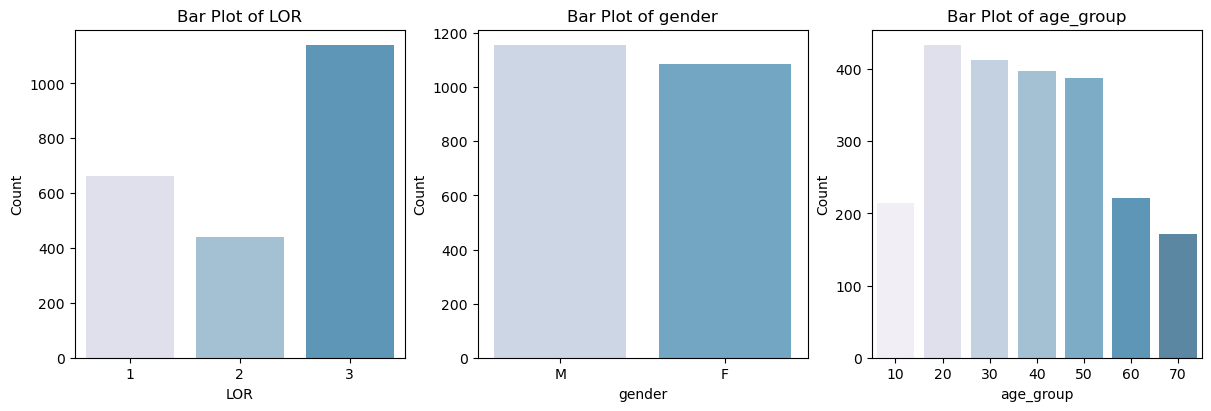

In [125]:
# Create the subplots
variables = ['LOR', 'gender', 'age_group'] 

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), constrained_layout=True)
ax = ax.flatten() 


for i, var in enumerate(variables):
        sns.barplot(x=basetable[var].value_counts().index, y=basetable[var].value_counts(), ax=ax[i], palette="PuBu", 
                    alpha=0.7)
        ax[i].set_title(f'Bar Plot of {var}')
        ax[i].set_xlabel(var)
        ax[i].set_ylabel('Count')

save_plot("Bar plots of three variables.png")
# Display the plots
plt.show()

In [126]:
for var in variables:
    print (basetable[var].value_counts())
    print("")

LOR
3    1139
1     661
2     439
Name: count, dtype: int64

gender
M    1155
F    1084
Name: count, dtype: int64

age_group
20    433
30    413
40    398
50    388
60    221
10    215
70    171
Name: count, dtype: int64



In [127]:
for var in variables:
    print(var + " description and key numbers: ")
    print (basetable[var].describe())
    print("")

LOR description and key numbers: 
count    2239.000000
mean        2.213488
std         0.871029
min         1.000000
25%         1.000000
50%         3.000000
75%         3.000000
max         3.000000
Name: LOR, dtype: float64

gender description and key numbers: 
count     2239
unique       2
top          M
freq      1155
Name: gender, dtype: object

age_group description and key numbers: 
count    2239.000000
mean       37.405092
std        17.354316
min        10.000000
25%        20.000000
50%        40.000000
75%        50.000000
max        70.000000
Name: age_group, dtype: float64



#### 5.2 R Score, F Score, M Score and RFM Score

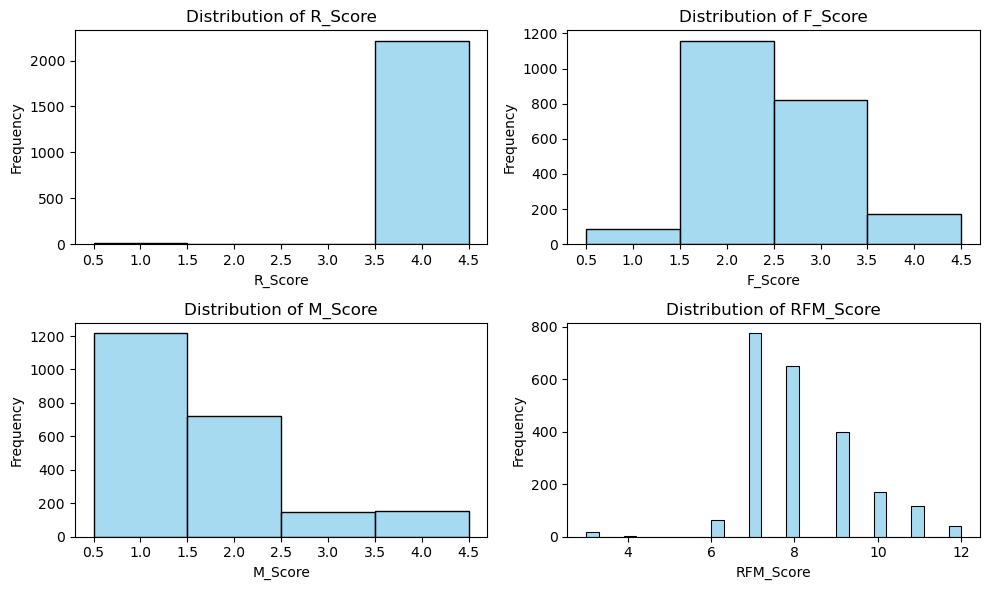

In [129]:
rfm_data = basetable[['R_Score', 'F_Score', 'M_Score', 'RFM_Score']]

fig, ax = plt.subplots(2, 2, figsize=(10,6))
ax = ax.flatten()

# Plot histograms
for i, score in enumerate(rfm_data.columns):
    sns.histplot(rfm_data[score], ax=ax[i], color='skyblue')
    ax[i].set_title(f'Distribution of {score}')
    ax[i].set_xlabel(score)
    ax[i].set_ylabel('Frequency')

plt.tight_layout()
save_plot("Distribution of four scores.png")
plt.show()

In [130]:
for var in rfm_data:
    print(basetable[var].value_counts())
    print("")

R_Score
4    2218
1      18
2       3
3       0
Name: count, dtype: int64

F_Score
2    1160
3     823
4     170
1      86
Name: count, dtype: int64

M_Score
1    1218
2     720
4     154
3     147
Name: count, dtype: int64

RFM_Score
7     777
8     650
9     398
10    170
11    119
6      63
12     41
3      18
4       3
Name: count, dtype: int64



In [131]:
for var in rfm_data:
    print(var + " description and key numbers: ")
    print (basetable[var].describe())
    print("")

R_Score description and key numbers: 
count     2239
unique       3
top          4
freq      2218
Name: R_Score, dtype: int64

F_Score description and key numbers: 
count     2239
unique       4
top          2
freq      1160
Name: F_Score, dtype: int64

M_Score description and key numbers: 
count     2239
unique       4
top          1
freq      1218
Name: M_Score, dtype: int64

RFM_Score description and key numbers: 
count    2239.000000
mean        8.113444
std         1.386644
min         3.000000
25%         7.000000
50%         8.000000
75%         9.000000
max        12.000000
Name: RFM_Score, dtype: float64



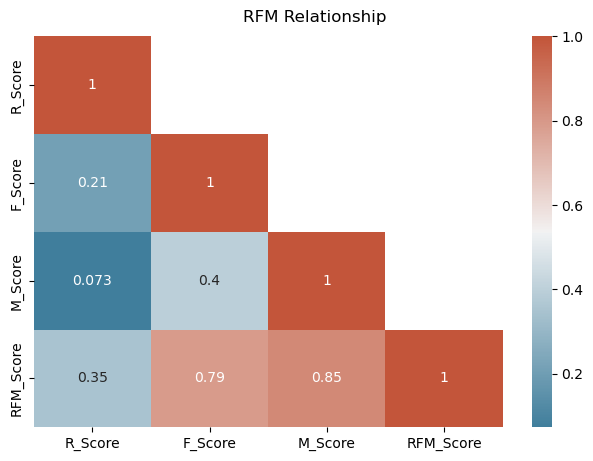

In [132]:
corr_matrix = rfm_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
cmap = sns.diverging_palette(230, 20, as_cmap = True)

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap=cmap)
plt.suptitle("RFM Relationship", y=0.95)
plt.tight_layout()
save_plot('Heatmap of RFM scores')
plt.show()

#### 5.3 Other independent variables

In [134]:
print(basetable[['stat_issued_after_trans', 'stat_issued_weekly']].value_counts())

stat_issued_after_trans  stat_issued_weekly
False                    False                 2069
                         True                   122
True                     False                   48
Name: count, dtype: int64


In [135]:
print(basetable['dist_salary_avg'].value_counts())

dist_salary_avg
Low salary       1436
Medium salary     497
High salary       306
Name: count, dtype: int64


In [136]:
pd.crosstab(basetable['Credit_F_Score'], basetable['Withdrawal_F_Score'])

Withdrawal_F_Score,1,2,3,4
Credit_F_Score,,,,
1,48,6,3,0
2,22,814,545,131
3,5,231,188,37
4,1,90,97,21


#### 5.4 Dependent variables: granted_loan, card_issued

5.4.1 Basic statistics and distribution

In [139]:
pd.crosstab(basetable['granted_loan'], basetable['card_issued'])

card_issued,0,1
granted_loan,,
0,2093,115
1,26,5


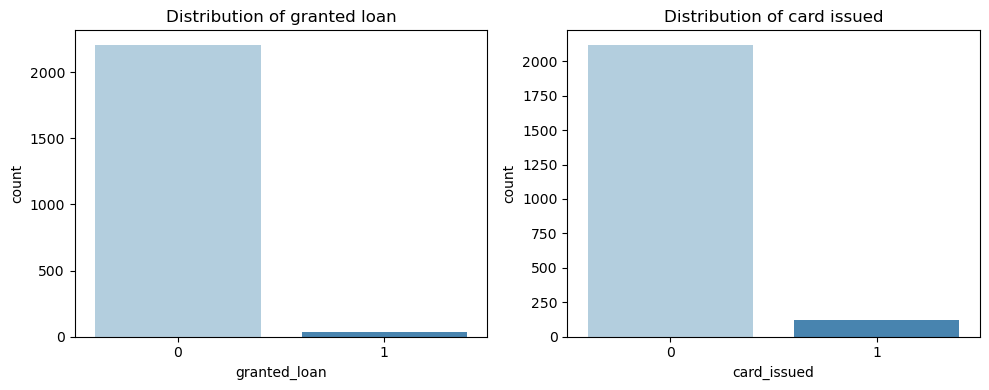

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x='granted_loan', data=basetable, ax=ax[0], palette = 'Blues', hue = 'granted_loan', legend=False)
ax[0].set_title('Distribution of granted loan')

sns.countplot(x='card_issued', data=basetable, ax=ax[1], palette = 'Blues', hue = 'card_issued', legend=False)
ax[1].set_title('Distribution of card issued')

plt.tight_layout()
save_plot("Distribution of dependent variables.png")
plt.show()

5.4.2 Relationship between independent variables and target variables

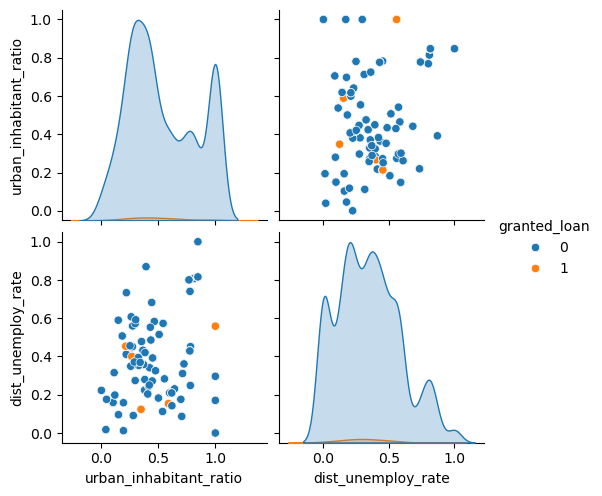

In [142]:
pairplot = sns.pairplot(basetable, hue='granted_loan', vars=['urban_inhabitant_ratio', 'dist_unemploy_rate'])
save_plot("Relationships between two independent variables and granted loan.png")

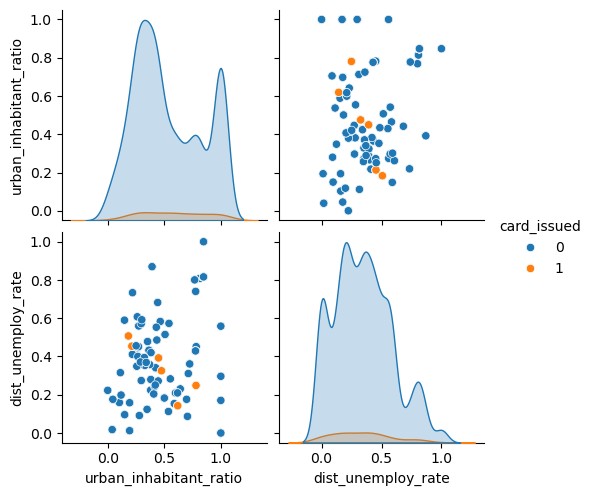

In [143]:
sns.pairplot(basetable, hue='card_issued', vars=['urban_inhabitant_ratio', 'dist_unemploy_rate'])
save_plot("Relationships between two independent variables and card issued.png")

In [144]:
basetable_corr=basetable

# Create a dummy variable for gender: 1 for female ('F') and 0 for male ('M')
basetable_corr['is_female']=basetable['gender'].map({'F': 1, 'M': 0})
# Convert 'stat_issued_after_trans' and 'stat_issued_weekly' to binary variables: 1 for True, 0 for False
basetable_corr['stat_issued_after_trans']=basetable['stat_issued_after_trans'].map({False: 0, True: 1})
basetable_corr['stat_issued_weekly']=basetable['stat_issued_weekly'].map({False: 0, True: 1})

basetable_corr=basetable.drop(['client_id', 'gender'], axis=1)

In [145]:
# Convert 'dist_salary_avg' into dummy variables
dist_salary_avg_encoded = pd.get_dummies(basetable_corr['dist_salary_avg'], drop_first= True)
basetable_corr = pd.concat([basetable_corr, dist_salary_avg_encoded], axis= 1)
basetable_corr = basetable_corr.drop('dist_salary_avg', axis=1)

# Convert the 'Medium salary' and 'High salary' dummy variables to binary: 1 for True, 0 for False
basetable_corr['Medium salary']=basetable_corr['Medium salary'].map({False: 0, True: 1})
basetable_corr['High salary']=basetable_corr['High salary'].map({False: 0, True: 1})
basetable_corr.head()

,LOR,age_group,urban_inhabitant_ratio,dist_unemploy_rate,R_Score,F_Score,M_Score,RFM_Score,Credit_F_Score,Withdrawal_F_Score,...,log_total_withdrawal,log_avg_amount_trans_96,log_transaction_std,log_avg_balance,log_balance_std,granted_loan,card_issued,is_female,Medium salary,High salary
0,3,60,1.000000,0.558528,4,2,1,7,2,2,...,11.162221,7.767759,7.811576,10.412226,7.811576,0,0,1,1,0
1,3,60,1.000000,0.000000,4,3,2,9,2,4,...,12.317324,8.450403,8.720212,10.759780,8.720212,0,0,0,0,1
2,3,50,0.279879,0.091416,4,3,2,9,2,3,...,12.294684,8.579600,8.863471,10.178616,8.863471,0,0,0,0,0
3,3,20,0.347958,0.123746,4,3,4,11,3,3,...,13.358716,9.657383,9.667812,11.181321,9.667812,0,0,1,0,0
4,3,50,0.697428,0.176143,4,3,2,9,2,4,...,12.160401,8.256968,8.570591,10.139420,8.570591,0,0,0,0,0


In [146]:
basetable_corr.columns

Index(['LOR', 'age_group', 'urban_inhabitant_ratio', 'dist_unemploy_rate',
       'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Credit_F_Score',
       'Withdrawal_F_Score', 'stat_issued_after_trans', 'stat_issued_weekly',
       'log_total_credit', 'log_total_withdrawal', 'log_avg_amount_trans_96',
       'log_transaction_std', 'log_avg_balance', 'log_balance_std',
       'granted_loan', 'card_issued', 'is_female', 'Medium salary',
       'High salary'],
      dtype='object')

In [147]:
#change sequence
basetable_ = basetable_corr[['LOR', 'age_group', 'urban_inhabitant_ratio', 'dist_unemploy_rate',
       'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Credit_F_Score',
       'Withdrawal_F_Score', 'stat_issued_after_trans', 'stat_issued_weekly',
       'log_total_credit', 'log_total_withdrawal', 'log_avg_amount_trans_96',
       'log_transaction_std', 'log_avg_balance', 'log_balance_std',
        'is_female', 'Medium salary','High salary',
        'granted_loan', 'card_issued']]

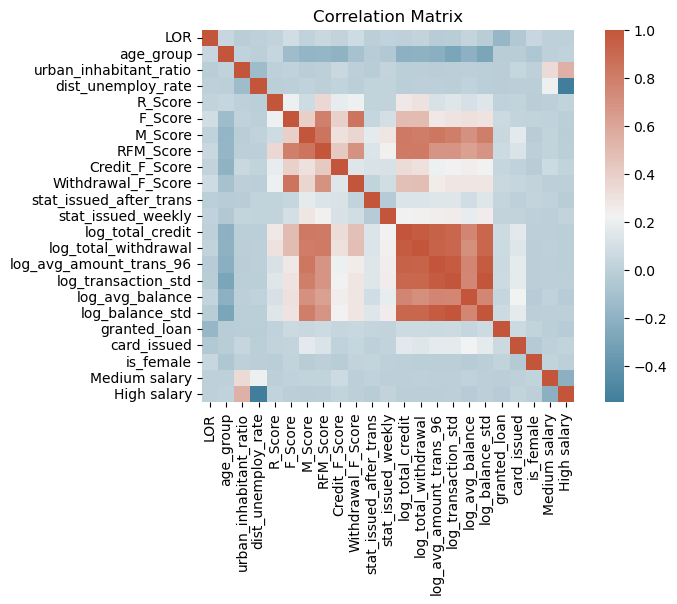

In [148]:
corr_matrix = basetable_corr.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap=cmap,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.index, square=True)

# Set the title and show the plot
plt.tight_layout()
plt.title("Correlation Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
save_plot('Correlation matrix')
plt.show()